In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from glob import glob
import scipy.signal as signal
import cartopy.crs as ccrs
import cmaps
import cartopy.feature as cf
import cmocean

In [2]:

def filter_timeseries(ts, order, cutoff, btype='lowpass', fs=1, **kwargs):
    """Given an array, this function apply a butterworth (high/low pass) 
    filter of the given order and cutoff frequency.
    For example:
    If 'ts' is a timeseries of daily samples, filter_timeseries(ts,3,1/20)
    will return the series without the 20 days or less variability using an
    order 3 butterworth filter. 
    In the same way, filter_timeseries(ts,3,1/20, btype='highpass') will
    return the series with only the 20 days or less variability.

    Args:
        ts (array_like): timeseries or 1D array to filter
        order (int): _description_
        cutoff (array_like): Single float for lowpass or highpass filters, 
        arraylike for bandpass filters.
        btype (str, optional): Th type of filter. Defaults to 'lowpass'.
        fs (int): Sampling frequency. Defaults to 1
        **kwargs are passed to scipy.signal.filtfilt

    Returns:
        output (array): Filtered array
    """
    mask = np.isnan(ts)
    nans = np.ones(len(ts))*np.nan
    if mask.sum()==len(ts):
        return nans
    else:
        b, a = signal.butter(order, cutoff, btype=btype, fs=fs)
        filt=signal.filtfilt(b, a, ts[~mask], **kwargs)
        output=np.ones(len(ts))*np.nan
        output[np.where(~mask)] = filt
        return output
    
def filter_xarray(data, dim, order, cutoff, btype='lowpass', parallel=False, fs=1):
    """Given a 3d DataArray, with time and spatial coordinates, this function apply
    the 1D function filter_timeseries along the time dimension, filter the complete
    xarray data.

    Args:
        data (XDataArray): data
        dim (str): name of the time dimension
        order (int): butterworth filter order
        cutoff (array_like): if float, the cutoff frequency, if array must be the
                            [min,max] frequencys for the bandpass filter.
        btype (str, optional): {lowpass,highpass,bandpass}. Defaults to 'lowpass'.
        parallel (bool, optional): If parallelize with dask. Defaults to False.
        fs (int, optional): Sampling frequency. Defaults to 1.

    Returns:
        XDataArray: filtered data
    """
    if parallel:
        dask='parallelized'
    else:
        dask='forbidden'
    filt = xr.apply_ufunc(filter_timeseries, data, order, cutoff, btype, fs,
                          input_core_dims=[[dim],[],[],[],[]],
                          output_core_dims=[[dim]],
                          exclude_dims=set((dim,)),
                          keep_attrs=True,
                          vectorize=True, dask=dask)
    filt[dim] = data[dim]
    return filt



---

##### load data


In [3]:
masks_reforecast = xr.open_dataset('data/REFORECASTS_MASKS.nc')
masks_glorys     = xr.open_dataset('data/GLORYS_MASKS.nc')

In [4]:
#LOAD DATA

tropical_glorys_clim       = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_tropical.nc').drop('sst')
coastnorth_glorys_clim     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_coastnorth.nc').drop('sst')
coastsouth_glorys_clim     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_coastsouth.nc').drop('sst')

tropical_reforecast_clim   = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_tropical_clim.nc')
coastnorth_reforecast_clim = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_coastnorth_clim.nc')
coastsouth_reforecast_clim = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_coastsouth_clim.nc')

tropical_glorys       = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_tropical.nc').convert_calendar('noleap', dim='time').drop('sst')
tropical_reforecast   = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_tropical.nc').convert_calendar('noleap', dim='inittime')

coastnorth_glorys     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_coastnorth.nc').convert_calendar('noleap', dim='time').drop('sst')
coastnorth_reforecast = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_coastnorth.nc').convert_calendar('noleap', dim='inittime')

coastsouth_glorys     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_coastsouth.nc').convert_calendar('noleap', dim='time').drop('sst')
coastsouth_reforecast = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_coastsouth.nc').convert_calendar('noleap', dim='inittime')

In [5]:
# COMPUTE REANALYSIS ANOMALIES
north_glorys = xr.concat([tropical_glorys.groupby('time.dayofyear')-tropical_glorys_clim,
                          coastnorth_glorys.groupby('time.dayofyear')-coastnorth_glorys_clim
                         ],'index').convert_calendar('gregorian').drop('dayofyear')

south_glorys = xr.concat([tropical_glorys.groupby('time.dayofyear')-tropical_glorys_clim,
                          coastsouth_glorys.groupby('time.dayofyear')-coastsouth_glorys_clim
                         ],'index').convert_calendar('gregorian').drop('dayofyear')


In [6]:
# COMPUTE ANOMALY FORECAST
north_reforecast = xr.concat([tropical_reforecast.groupby('inittime.dayofyear')-tropical_reforecast_clim,
                          coastnorth_reforecast.groupby('inittime.dayofyear')-coastnorth_reforecast_clim
                         ],'index').convert_calendar('gregorian', dim='inittime').drop('dayofyear').drop_duplicates(
                             'inittime').interp({'inittime':north_glorys.time.values}).bfill('inittime').ffill('inittime')

south_reforecast = xr.concat([tropical_reforecast.groupby('inittime.dayofyear')-tropical_reforecast_clim,
                          coastsouth_reforecast.groupby('inittime.dayofyear')-coastsouth_reforecast_clim
                         ],'index').convert_calendar('gregorian', dim='inittime').drop('dayofyear').drop_duplicates(
                             'inittime').interp({'inittime':north_glorys.time.values}).bfill('inittime').ffill('inittime')

In [11]:
north_persistance = north_glorys.copy().expand_dims({'leadtime':46}).rename({'time':'inittime'})
north_persistance.coords['leadtime'] = ('leadtime', range(46))

south_persistance = south_glorys.copy().expand_dims({'leadtime':46}).rename({'time':'inittime'})
south_persistance.coords['leadtime'] = ('leadtime', range(46))

In [ ]:
# north_glorys_filtered = filter_xarray(north_glorys,'time',5,1/60,btype='highpass').swap_dims({'index':'distance'})
# north_glorys_filtered = filter_xarray(north_glorys_filtered,'distance',5,1/100).swap_dims({'distance':'index'})

# south_glorys_filtered = filter_xarray(south_glorys,'time',5,1/60,btype='highpass').swap_dims({'index':'distance'})
# south_glorys_filtered = filter_xarray(south_glorys_filtered,'distance',5,1/100).swap_dims({'distance':'index'})

# north_reforecast_filtered = filter_xarray(north_reforecast.drop_duplicates('inittime'),'inittime',5,1/60,btype='highpass').swap_dims({'index':'distance'})
# north_reforecast_filtered = filter_xarray(north_reforecast_filtered.drop_duplicates('distance'),'distance',5,1/10).swap_dims({'distance':'index'})

# south_reforecast_filtered = filter_xarray(south_reforecast.drop_duplicates('inittime'),'inittime',5,1/60,btype='highpass').swap_dims({'index':'distance'})
# south_reforecast_filtered = filter_xarray(south_reforecast_filtered.drop_duplicates('distance'),'distance',5,1/10).swap_dims({'distance':'index'})

---

#### overall skill analysis

In [ ]:
skillsouth = []
skillnorth = []
for h in ['south','north']:
    for v in ['T300','zos']:
        baseline = eval(h+'_glorys').swap_dims({'index':'distance'}).rolling({'time':12}, center=True).mean().interp(distance=eval(h+'_reforecast').distance.values, method='nearest')[v]
        forecast = eval(h+'_reforecast').swap_dims({'index':'distance'})[v]
        skill = []
        for lead in forecast.leadtime.values:
            x = forecast.sel(leadtime=lead).drop_duplicates('inittime')
            x.coords['time'] = x.inittime+pd.Timedelta(days=lead)
            x = x.swap_dims({'inittime':'time'})
            x.coords['inittime'] = x.time-pd.Timedelta(days=lead)
            skill.append(xr.corr(x,baseline,'time')**2)
        skill = xr.concat(skill,'leadtime')
        eval('skill'+h).append(skill)
skillsouth = xr.merge(skillsouth)
skillnorth = xr.merge(skillnorth)


Text(0.5, 1.0, 'T300 ANOMALY \n\n')

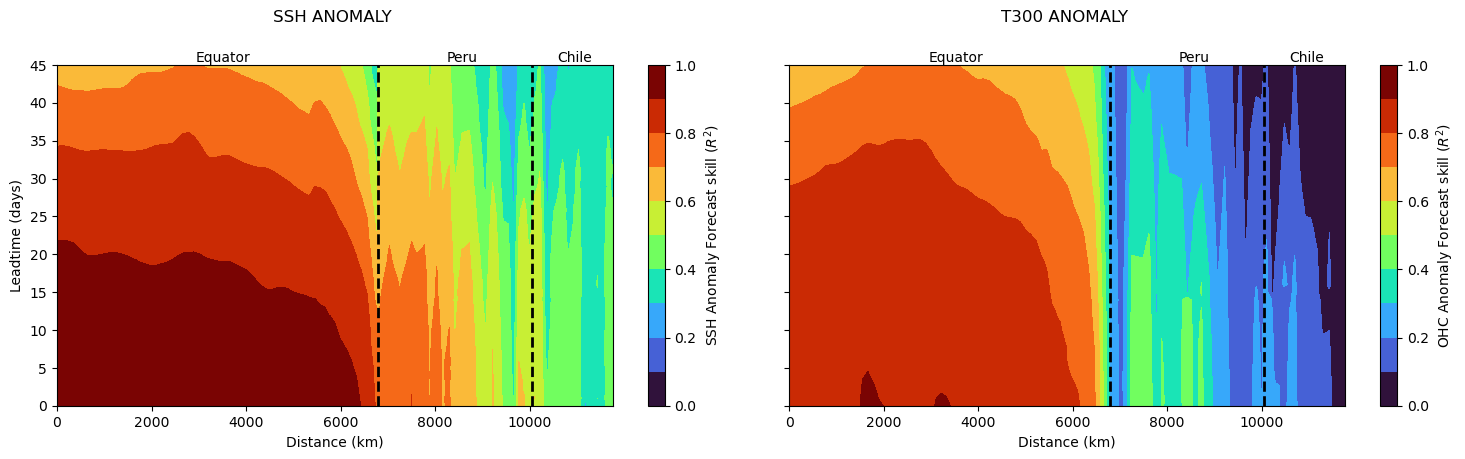

In [ ]:
fig, ax = plt.subplots(1,2, sharex='col', sharey=True, facecolor='w', dpi=100, figsize=(15,4))
fig.tight_layout()
skillsouth.zos.plot.contourf(ax=ax[0], levels=np.arange(0,1+0.1,0.1), cmap='turbo', cbar_kwargs={'label':'SSH Anomaly Forecast skill ($R^2$)'})
skillsouth.T300.plot.contourf(ax=ax[1], levels=np.arange(0,1+0.1,0.1), cmap='turbo', cbar_kwargs={'label':'OHC Anomaly Forecast skill ($R^2$)'})
ticks = (list(map(lambda x: str(int(x))+'°W',list(360-x.lon[:62].values))))+list(map(lambda x: str(int(x))+'°S',list(x.lat[62:].values)))
for axis in ax.ravel():
    axis.set_xlabel('Distance (km)')
    axis.set_ylabel('')
    axis.axvline(6783.89008117, color='k', linestyle="--", lw=2)
    axis.axvline(10040.17673306, color='k', linestyle="--", lw=2)
    axis.text(0.25,1.01,'Equator', transform=axis.transAxes)
    axis.text(0.7,1.01,'Peru', transform=axis.transAxes)
    axis.text(0.9,1.01,'Chile', transform=axis.transAxes)
    
ax[0].set_ylabel('Leadtime (days)')
ax[0].set_title('SSH ANOMALY \n\n')
ax[1].set_title('T300 ANOMALY \n\n')



In [ ]:
skillsouth = []
skillnorth = []
for h in ['south','north']:
    for v in ['T300','zos']:
        baseline = eval(h+'_glorys').swap_dims({'index':'distance'}).rolling({'time':12}, center=True).mean().interp(distance=eval(h+'_reforecast').distance.values, method='nearest')[v]
        forecast = eval(h+'_reforecast').swap_dims({'index':'distance'})[v]
        skill = []
        for lead in forecast.leadtime.values:
            x = forecast.sel(leadtime=lead).drop_duplicates('inittime')
            x.coords['time'] = x.inittime+pd.Timedelta(days=lead)
            x = x.swap_dims({'inittime':'time'})
            x.coords['inittime'] = x.time-pd.Timedelta(days=lead)
            skill.append(((x-baseline)**2).mean('time')**0.5)
        skill = xr.concat(skill,'leadtime')
        eval('skill'+h).append(skill)
skillsouth = xr.merge(skillsouth)
skillnorth = xr.merge(skillnorth)


Text(0.5, 1.0, 'T300 ANOMALY \n\n')

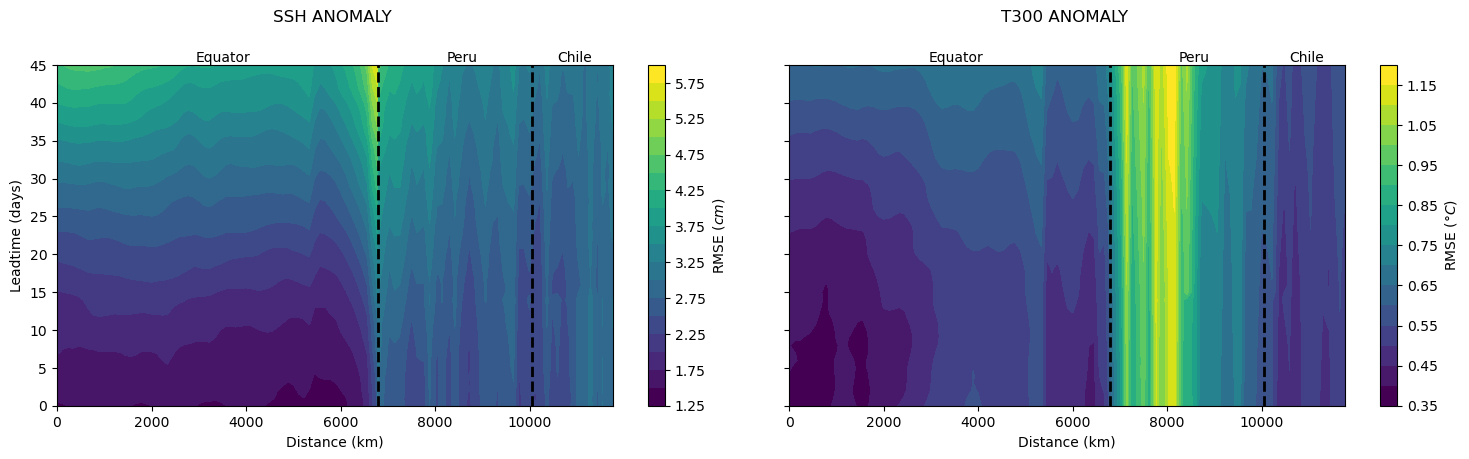

In [ ]:
fig, ax = plt.subplots(1,2, sharex='col', sharey=True, facecolor='w', dpi=100, figsize=(15,4))
fig.tight_layout()
(skillsouth.zos*100).plot.contourf(ax=ax[0], levels=20, cmap='viridis', cbar_kwargs={'label':'RMSE ($cm$)'})
skillsouth.T300.plot.contourf(ax=ax[1], levels=20, cmap='viridis', cbar_kwargs={'label':'RMSE ($°C$)'})
ticks = (list(map(lambda x: str(int(x))+'°W',list(360-x.lon[:62].values))))+list(map(lambda x: str(int(x))+'°S',list(x.lat[62:].values)))
for axis in ax.ravel():
    axis.set_xlabel('Distance (km)')
    axis.set_ylabel('')
    axis.axvline(x.distance[62], color='k', linestyle="--", lw=2)
    axis.axvline(x.distance[76], color='k', linestyle="--", lw=2)
    axis.text(0.25,1.01,'Equator', transform=axis.transAxes)
    axis.text(0.7,1.01,'Peru', transform=axis.transAxes)
    axis.text(0.9,1.01,'Chile', transform=axis.transAxes)
    
ax[0].set_ylabel('Leadtime (days)')
ax[0].set_ylabel('Leadtime (days)')
ax[0].set_title('SSH ANOMALY \n\n')
ax[1].set_title('T300 ANOMALY \n\n')




---

##### ANALYSIS BY ZONES

In [12]:
zones_south = {'NorthPeru':slice(-4,-8),
               'SouthPeru':slice(-13,-16),
               'Atacama':slice(-21,-25),
               'CentralChile':slice(-29,-31)}

zones_north = {'SouthCCS':slice(30,34)}

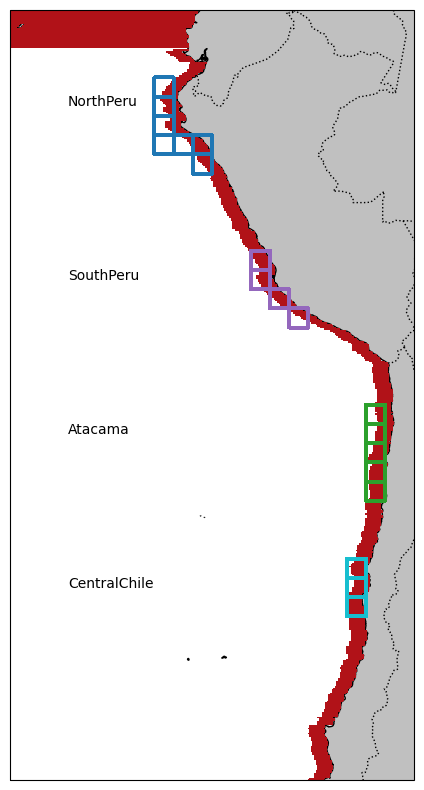

In [55]:
fig, ax = plt.subplots(1,1, figsize=(10,10), dpi=100, facecolor='w', subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines('10m')
ax.set_extent([-90,-69,-40,0])
masks_glorys.tropicalmask.where(masks_glorys.tropicalmask).plot(ax=ax, add_colorbar=False, vmin=0, vmax=1.2, cmap='Reds')
masks_glorys.coastmask_south.where(masks_glorys.coastmask_south).plot(ax=ax, add_colorbar=False, vmin=0, vmax=1.2, cmap='Reds')
ax.add_feature(cf.LAND, color='silver')
ax.add_feature(cf.BORDERS, ls=':')

colors=plt.cm.tab10(np.linspace(0,1,10))[[0,4,2,9],:]
for i,z in enumerate(zones_south.keys()):    
    x = masks_reforecast.coastmask_south.sortby('lat',ascending=False).sel(lat=zones_south[z])
    x = x.where(x==1)
    ax.pcolor(x.lon,x.lat,x, color=colors[i], facecolor='none', linewidth=2)
    ax.text(-87, x.lat[1], z, transform=ax.transData)

# colors=plt.cm.tab10(np.linspace(0.8,1,10))
# for i,z in enumerate(zones_north.keys()):    
#     x = masks_reforecast.coastmask_north.sortby('lat',ascending=True).sel(lat=zones_north[z])
#     x = x.where(x==1)
#     ax.pcolor(x.lon,x.lat,x, color=colors[i], facecolor='none', linewidth=2)



In [36]:
zsouth_reforecast  = {keys:south_reforecast.swap_dims({'index':'lat'}).sel(lat=zones_south[keys]).mean('lat') for keys in zones_south.keys()}
zsouth_persistance = {keys:south_persistance.swap_dims({'index':'lat'}).sel(lat=zones_south[keys]).mean('lat') for keys in zones_south.keys()}
zsouth_glorys      = {keys:south_glorys.swap_dims({'index':'lat'}).sel(lat=zones_south[keys]).mean('lat') for keys in zones_south.keys()}

znorth_reforecast  = {keys:north_reforecast.swap_dims({'index':'lat'}).sel(lat=zones_north[keys]).mean('lat') for keys in zones_north.keys()}
znorth_persistance = {keys:north_persistance.swap_dims({'index':'lat'}).sel(lat=zones_north[keys]).mean('lat') for keys in zones_north.keys()}
znorth_glorys      = {keys:north_glorys.swap_dims({'index':'lat'}).sel(lat=zones_north[keys]).mean('lat') for keys in zones_north.keys()}


In [120]:
y

<xarray.Dataset>
Dimensions:   (leadtime: 46, lags: 46)
Coordinates:
  * leadtime  (leadtime) int64 0 1 2 3 4 5 6 7 8 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: lags
Data variables:
    zos       (leadtime, lags) float64 1.0 0.9976 0.9918 ... 0.6664 0.6608

In [121]:
zsouth_reforecast_autocorrelation  = {keys:zsouth_reforecast[keys].copy() for keys in zones_south.keys()}
zsouth_persistance_autocorrelation = {keys:zsouth_persistance[keys].copy() for keys in zones_south.keys()}
for z in zones_south.keys():
    print(z,'reforecast')
    data = zsouth_reforecast_autocorrelation[z]
    x = data.zos
    y = data.T300
    x = xr.concat([xr.concat([xr.corr(x.isel(leadtime=lead),x.isel(leadtime=lead).shift({'inittime':i})) for i in range(46)],'lags') for lead in range(len(x.leadtime))],'leadtime')
    y = xr.concat([xr.concat([xr.corr(y.isel(leadtime=lead),y.isel(leadtime=lead).shift({'inittime':i})) for i in range(46)],'lags') for lead in range(len(y.leadtime))],'leadtime')
    x = x.to_dataset(name='zos')
    y = y.to_dataset(name='T300')
    zsouth_reforecast_autocorrelation[z] = xr.merge([x,y])
    print(z,'persistance')
    data = zsouth_persistance_autocorrelation[z]
    x = data.zos
    y = data.T300
    x = xr.concat([xr.concat([xr.corr(x.isel(leadtime=lead),x.isel(leadtime=lead).shift({'inittime':i})) for i in range(46)],'lags') for lead in range(len(x.leadtime))],'leadtime')
    y = xr.concat([xr.concat([xr.corr(y.isel(leadtime=lead),y.isel(leadtime=lead).shift({'inittime':i})) for i in range(46)],'lags') for lead in range(len(y.leadtime))],'leadtime')
    x = x.to_dataset(name='zos')
    y = y.to_dataset(name='T300')
    zsouth_persistance_autocorrelation[z] = xr.merge([x,y])
    
    
    

NorthPeru reforecast
NorthPeru persistance
SouthPeru reforecast
SouthPeru persistance
Atacama reforecast
Atacama persistance
CentralChile reforecast
CentralChile persistance


In [126]:
zsouth_reforecast_autocorrelation[z]

<xarray.Dataset>
Dimensions:   (leadtime: 46, lags: 46)
Coordinates:
  * leadtime  (leadtime) int64 0 1 2 3 4 5 6 7 8 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: lags
Data variables:
    zos       (leadtime, lags) float64 1.0 0.9825 0.9496 ... 0.5455 0.5421
    T300      (leadtime, lags) float64 1.0 0.9981 0.9929 ... 0.6916 0.6844

In [51]:
# persistance forecast skill
# try:
#     zsouth_skill_persistance = {keys: xr.open_dataset('data/skill_persistance_{}.nc'.format(keys)) for keys in zones_south.keys()}
# except:
zsouth_skill_persistance = {keys:None for keys in zones_south.keys()}
for z in list(zones_south.keys()):
    print(z,'\n')
    reforecast = zsouth_persistance[z]
    glorys     = zsouth_glorys[z]
    glorys.coords['time'] = glorys.time-pd.Timedelta(hours=12)
    glorys = glorys.convert_calendar('noleap')
    skill = []
    for lead in reforecast.leadtime.values:
        if lead%6==1:
            print('lead',lead)
        x = reforecast.sel(leadtime=lead).drop_duplicates('inittime').convert_calendar('noleap','inittime')
        x.coords['time'] = x.inittime+pd.Timedelta(days=lead)
        x = x.swap_dims({'inittime':'time'})
        x = x.interp(time=glorys.time.values).dropna('time')
        x.coords['inittime'] = x.time-pd.Timedelta(days=lead)
        y = glorys.sel(time=x.time.values)
        x = x.groupby('inittime.dayofyear')
        skilldayofyear = []
        for i in range(1,365+1):
            c = []
            for v in x[i].keys():
                c.append(xr.corr(x[i][v],y[v],'time'))
            skilldayofyear.append(xr.merge(c))
        skill.append(xr.concat(skilldayofyear, 'dayofyear'))
    skill = xr.concat(skill,'leadtime')
    zsouth_skill_persistance[z] = skill.copy()

NorthPeru 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43
SouthPeru 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43
Atacama 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43
CentralChile 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43


In [42]:
# persistance forecast skill

try:
    zsouth_skill = {keys: xr.open_dataset('data/skill_{}.nc'.format(keys)) for keys in zones_south.keys()}
except:
    zsouth_skill = {keys:None for keys in zones_south.keys()}
    for z in list(zones_south.keys()):
        print(z,'\n')
        reforecast = zsouth_reforecast[z]
        glorys     = zsouth_glorys[z]
        glorys.coords['time'] = glorys.time-pd.Timedelta(hours=12)
        glorys = glorys.convert_calendar('noleap')
        skill = []
        for lead in reforecast.leadtime.values:
            if lead%6==1:
                print('lead',lead)
            x = reforecast.sel(leadtime=lead).drop_duplicates('inittime').convert_calendar('noleap','inittime')
            x.coords['time'] = x.inittime+pd.Timedelta(days=lead)
            x = x.swap_dims({'inittime':'time'})
            x = x.interp(time=glorys.time.values).dropna('time')
            x.coords['inittime'] = x.time-pd.Timedelta(days=lead)
            y = glorys.sel(time=x.time.values)
            x = x.groupby('inittime.dayofyear')
            skilldayofyear = []
            for i in range(1,365+1):
                c = []
                for v in x[i].keys():
                    c.append(xr.corr(x[i][v],y[v],'time'))
                skilldayofyear.append(xr.merge(c))
            skill.append(xr.concat(skilldayofyear, 'dayofyear'))
        skill = xr.concat(skill,'leadtime')
        zsouth_skill[z] = skill.copy()

Text(0, 0.5, 'OCEAN HEAT CONTENT\nANOMALY SKILL\n\nleadtime\n(days)')

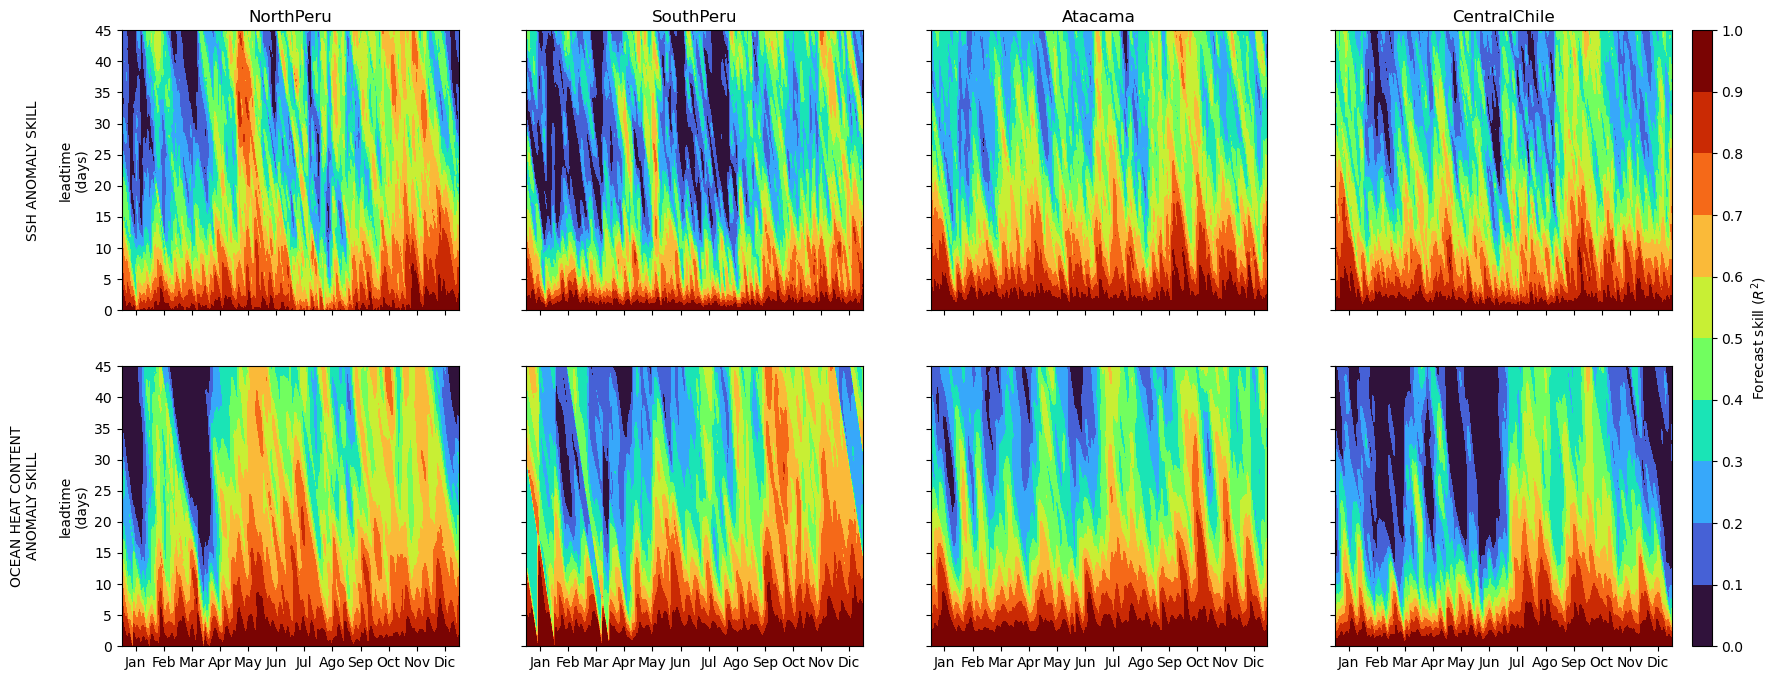

In [56]:
fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, facecolor='w', dpi=100, figsize=(20,8))


for i,z in enumerate(list(zones_south.keys())):
    x,y = zsouth_skill[z].dayofyear,zsouth_skill[z].leadtime
    X,Y = np.meshgrid(x,y)
    m=(zsouth_skill_persistance[z].zos**2).plot.contourf(ax=ax[0,i], cmap='turbo', levels=np.arange(0,1.1,0.1), add_colorbar=False)
    m=(zsouth_skill_persistance[z].T300**2).plot.contourf(ax=ax[1,i], cmap='turbo', levels=np.arange(0,1.1,0.1), add_colorbar=False)
    
    # mask = (zsouth_skill[z].zos**2>2*zsouth_skill_persistance[z].zos**2)
    # ax[0,i].scatter(np.where(mask==1, X, np.nan).ravel(),np.where(mask==1, Y, np.nan).ravel(), s=0.1, marker='X', color='tab:red') #mask.where(mask==0).values.ravel())
    # mask = (zsouth_skill[z].T300**2>2*zsouth_skill_persistance[z].T300**2)
    # ax[1,i].scatter(np.where(mask==1, X, np.nan).ravel(),np.where(mask==1, Y, np.nan).ravel(), s=0.1, marker='X', color='tab:red') #mask.where(mask==0).values.ravel())
    ax[0,i].set_xticks(np.linspace(15,349,12))
    ax[0,i].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'])
    ax[0,i].set_yticks(np.arange(0,46,5))
    ax[0,i].set_xlabel('')
    ax[0,i].set_ylabel('')
    ax[1,i].set_xlabel('')
    ax[1,i].set_ylabel('')
    ax[0,i].set_title(z)
    
    
box1 = ax[0,-1].get_position()
box2 = ax[1,-1].get_position()
cax  = fig.add_axes([box1.xmax+0.01,box2.ymin,0.01, -box2.ymin+box1.ymax])
fig.colorbar(m, cax=cax, label='Forecast skill ($R^2$)', ticks=np.arange(0,1.1,0.1))

ax[0,0].set_ylabel('SSH ANOMALY SKILL\n\nleadtime\n(days)')
ax[1,0].set_ylabel('OCEAN HEAT CONTENT\nANOMALY SKILL\n\nleadtime\n(days)')
# fig.tight_layout()

Text(0, 0.5, 'OHC ANOMALY SKILL\n\nleadtime\n(days)')

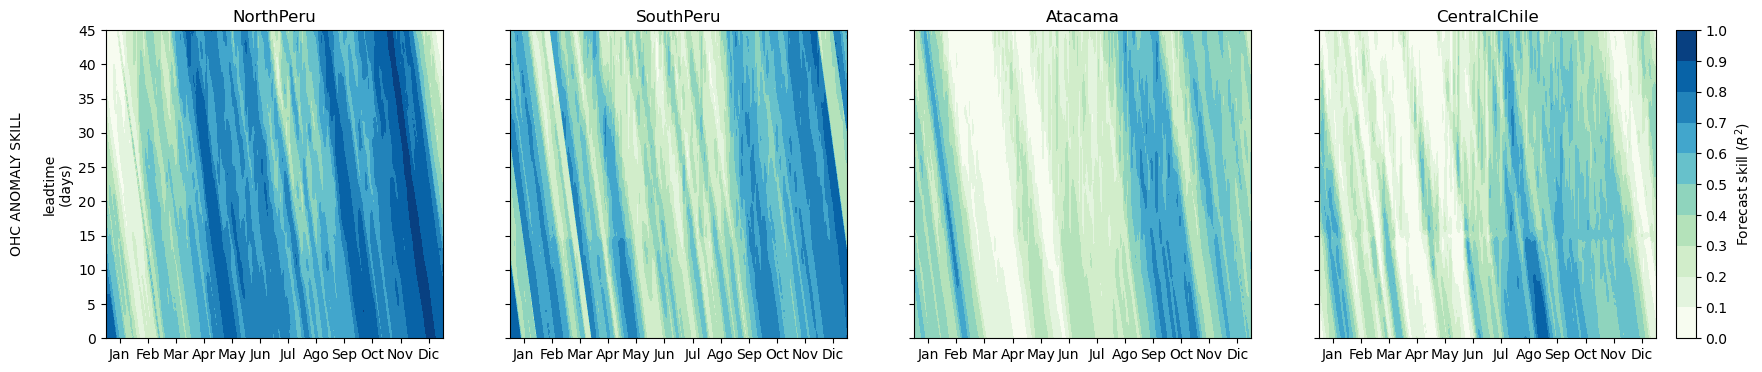

In [138]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, facecolor='w', dpi=100, figsize=(20,4))


for i,z in enumerate(list(zones_south.keys())):
    x,y = zsouth_skill[z].dayofyear,zsouth_skill[z].leadtime
    X,Y = np.meshgrid(x,y)
    # m=(zsouth_skill[z].zos**2).plot.contourf(ax=ax[i], cmap='GnBu', levels=np.arange(0,1.1,0.1), add_colorbar=False)
    m=(zsouth_skill[z].T300**2).plot.contourf(ax=ax[i], cmap='GnBu', levels=np.arange(0,1.1,0.1), add_colorbar=False)
    
    # mask = ((zsouth_skill[z].zos)>(1.0*zsouth_skill_persistance[z].zos))
    # ax[i].scatter(np.where(mask==1, X, np.nan).ravel(),np.where(mask==1, Y, np.nan).ravel(), s=0.1, marker='X', color='tab:red') #mask.where(mask==0).values.ravel())
    
    # ax[0,i].pcolor(X,Y,mask.where(mask==1), alpha=0, hatch='...')
   
    # mask = ((zsouth_skill[z].T300**2)>(1.0*zsouth_skill_persistance[z].T300**2))
    # ax[1,i].scatter(np.where(mask==1, X, np.nan).ravel(),np.where(mask==1, Y, np.nan).ravel(), s=0.1, marker='X', color='tab:red') #mask.where(mask==0).values.ravel())
    
    ax[i].set_xticks(np.linspace(15,349,12))
    ax[i].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'])
    ax[i].set_yticks(np.arange(0,46,5))
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(z)
    
    
box1 = ax[-1].get_position()
box2 = ax[-1].get_position()
cax  = fig.add_axes([box1.xmax+0.01,box2.ymin,0.01, -box2.ymin+box1.ymax])
fig.colorbar(m, cax=cax, label='Forecast skill ($R^2$)', ticks=np.arange(0,1.1,0.1))

ax[0].set_ylabel('OHC ANOMALY SKILL\n\nleadtime\n(days)')
# ax[1,0].set_ylabel('OCEAN HEAT CONTENT\nANOMALY SKILL\n\nleadtime\n(days)')
# fig.tight_layout()

In [87]:
import scipy.stats as st

class gaussian_gen(st.rv_continuous):
    def _pdf(self, x):
        return np.exp(-x**2/2)/np.sqrt(2*np.pi)
gaussian = gaussian_gen(name='gaussian')